# Web Scraping for Indeed.com & Predicting Salaries

The goal of this analysis is to predict the salary of Data Scientist salaries across the US, utilizing:

- Web Scraping
- Logistic Regressions

### Pull one sample for scraping

Implement pull for one page to use as a sample for a larger pull

In [3]:
#load all packages

import requests
import bs4
from bs4 import BeautifulSoup
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, recall_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [1]:
#set one URL

URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [3]:
#set as a request

r = requests.get("http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

In [5]:
#set as beautiful soup

ind_soup = BeautifulSoup(r.content, "lxml")

In [6]:
#print result to look at how the page is structured and how to find info we need

for item in ind_soup.findAll("div", class_=" row result"):
    print item.prettify()
    print ""
    print ""

<div class=" row result" data-jk="573189c2f3d45325" data-tn-component="organicJob" id="p_573189c2f3d45325" itemscope="" itemtype="http://schema.org/JobPosting">
 <h2 class="jobtitle" id="jl_573189c2f3d45325">
  <a class="turnstileLink" data-tn-element="jobTitle" href="/rc/clk?jk=573189c2f3d45325&amp;fccid=b48c1ad7c88be1fe" itemprop="title" onclick="setRefineByCookie(['salest']); return rclk(this,jobmap[0],true,0);" onmousedown="return rclk(this,jobmap[0],0);" rel="nofollow" target="_blank" title="Data Scientist">
   <b>
    Data
   </b>
   <b>
    Scientist
   </b>
  </a>
 </h2>
 <span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
  <span itemprop="name">
   Intent Media
  </span>
 </span>
 -
 <span itemprop="jobLocation" itemscope="" itemtype="http://schema.org/Place">
  <span class="location" itemprop="address" itemscope="" itemtype="http://schema.org/Postaladdress">
   <span itemprop="addressLocality">
    New York, NY
   </span>
  </span>


Results show that:

- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

In [5]:
#pull title

def title_from_code(result):
    titles = []
    for items in result.findAll("h2", class_="jobtitle"):
        titles.append(items.text)
    return titles

In [6]:
#pull location

def location_from_code(result):
    locations = []
    for items in result.findAll("span", class_="location"):
        locations.append(items.text)
    return locations

In [7]:
#pull company

def company_from_code(result):
    companies = []
    for items in result.findAll("span", class_ = "company"):
        items = items.text
        newitems = items.replace("\n", "")
        newitems = newitems.replace("    ", "")
        companies.append(newitems)
    return companies

In [8]:
#pull salary - have to put in "none" since not every listing has a salary

def salary_from_code(result):
    salaries = []
    for i in result.findAll("td", class_= "snip"):
        if i.find("nobr") != None:
            newitems = i.find("nobr").text
            newitems = newitems.replace(" a year", "")
            salaries.append(str(newitems))
        else:
            salaries.append("None")
    return salaries

### Apply the functions to pull key features from a larger set of data science jobs

In [11]:
#pull beautiful soups for a series of tech-focused cities 

url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 600

results = []
urllist = []

for city in set(['New+York', 'San+Francisco', 'Austin', "Seattle", "Boston", "Raleigh", "Charlotte", "Chicago", "Portland", "New+Orleans", "Denver"]):
    for start in range(0, max_results_per_city, 10):
        newurl = url_template.replace("{}", city, 1)
        newurl = newurl.replace("{}", str(start))
        urllist.append(newurl)

for url in urllist:
    r = requests.get(url)
    inds_soups = BeautifulSoup(r.content, "lxml")
    for item in inds_soups.findAll("div", class_=" row result"):
        results.append(item)

In [13]:
#apply functions to the beautiful soups, and use as lists

locations = []
title = []
company = []
salary = []

for item in results:
    locations.append(''.join(location_from_code(item)))
    title.append(''.join(title_from_code(item)))
    company.append(''.join(company_from_code(item)))
    salary.append(''.join(salary_from_code(item)))

In [14]:
#append into a dataframe

df = pd.DataFrame(locations, title)

df["salary"] = salary
df["company"] = company

In [17]:
#reset index 

df.reset_index(inplace = True)

In [19]:
#change column titles

df.columns = ["Title", "Location", "Salary", "Company"]
df.head()

,Title,Location,Salary,Company
0,\nStatistical Analyst\n,"Charlotte, NC",None,U.S. Bank
1,\nHR Data Analytics / Predictive Modeling Spec...,"Charlotte, NC",None,NRE
2,\nStatistician/Intermediate - Levine Cancer In...,"Charlotte, NC",None,Carolinas HealthCare System
3,\nResearch Analyst\n,"Charlotte, NC",None,Carolinas HealthCare System
4,\nData Science - Behavioral Analytics\n,"Charlotte, NC",None,Tom McDonald


In [20]:
#take a look at how the salary count is going - which looks a little off becuase most of it is not annual

df["Salary"].value_counts()

None                        4613
$7,300 - $8,500 a month       52
$7,083 - $9,166 a month       43
$150,000                       7
$200,000                       6
$5,400 - $6,500 a month        6
$130,000                       6
$6,250 - $10,833 a month       5
$20.65 an hour                 5
$140,000                       5
$85,000                        5
$150,000 - $200,000            4
$100,000 - $200,000            3
$115,000 - $150,000            3
$105,000                       3
$20 an hour                    3
$80,000 - $200,000             3
$100,000 - $150,000            3
$110,000 - $200,000            3
$140,000 - $160,000            3
$150,000 - $230,000            3
$110,000 - $150,000            3
$120,000 - $155,000            3
$115,000 - $135,000            2
$170,000                       2
$80,000 - $120,000             2
$135,000                       2
$90,000                        2
$57,393 - $95,037              2
$110,000 - $180,000            2
          

### Clean up the dataframe

Clean up the salaries

In [236]:
# Check on the dataframe types

df.dtypes

Title       object
Location    object
Salary      object
Company     object
dtype: object

In [21]:
#identify which rows have salaries that are not annual

print df.loc[df['Salary'].str.contains("hour")].index.tolist()
print df.loc[df['Salary'].str.contains("month")].index.tolist()
print df.loc[df['Salary'].str.contains("week")].index.tolist()
print df.loc[df['Salary'].str.contains("day")].index.tolist()

[572, 577, 609, 762, 799, 994, 1140, 1200, 1226, 1326, 1338, 1378, 1398, 1591, 1667, 1960, 2081, 2133, 2837, 2853, 2867, 2899, 2925, 2933, 2937, 2945, 2953, 2970, 2974, 2982, 2989, 2999, 3279, 3767, 3798, 3825, 3826, 4219, 4302, 4431, 4441, 4656, 4747, 4750, 4754, 4766, 4784]
[1236, 2206, 3762, 3792, 3800, 3807, 3832, 3839, 3841, 3848, 3855, 3862, 3869, 3876, 3883, 3890, 3897, 3904, 3911, 3918, 3925, 3932, 3939, 3946, 3953, 3960, 3967, 3974, 3981, 3988, 3995, 4002, 4009, 4016, 4023, 4030, 4037, 4044, 4051, 4058, 4065, 4072, 4079, 4086, 4093, 4100, 4107, 4114, 4121, 4128, 4135, 4142, 4149, 4156, 4163, 4170, 4177, 4184, 4191, 4253, 4275, 4276, 4305, 4311, 4411, 4430, 4482, 4496, 4602, 4667, 4719, 4741, 4755, 4756, 4757, 4758, 4764, 4768, 4770, 4772, 4792, 4796, 4807, 4818, 4827, 4829, 4830, 4835, 4839, 4850, 4883, 4889, 4900, 4902, 4904, 4906, 4908, 4910, 4912, 4914, 4916, 4918, 4920, 4922, 4924, 4926, 4928, 4930, 4932, 4934, 4936, 4938, 4940, 4942, 4944, 4946, 4948, 4950, 4952, 4954, 49

In [22]:
#put these into a list

removeindex = []
removeindex.append(df.loc[df['Salary'].str.contains("hour")].index.tolist())
removeindex.append(df.loc[df['Salary'].str.contains("month")].index.tolist())
removeindex.append(df.loc[df['Salary'].str.contains("week")].index.tolist())
removeindex.append(df.loc[df['Salary'].str.contains("day")].index.tolist())

In [23]:
#flatten list

removeindexfinal = [val for sublist in removeindex for val in sublist]

In [25]:
#remove all non-annual salaries

df.drop(df.index[removeindexfinal], inplace = True)

In [26]:
#check the remaining salaries

df["Salary"].unique()

array(['None', '$110,000 - $200,000', '$100,000 - $150,000',
       '$45,001 - $55,000', '$175,000 - $250,000', '$105,000', '$85,000',
       '$80,000 - $110,000', '$115,000 - $150,000', '$150,000', '$145,000',
       '$95,000', '$71,000', '$140,000', '$110,000 - $160,000',
       '$80,000 - $100,000', '$100,000 - $120,000', '$50,000 - $60,000',
       '$150,000 - $200,000', '$110,000 - $150,000', '$70,000 - $110,000',
       '$65,000 - $90,000', '$120,000 - $155,000', '$75,000 - $95,000',
       '$130,000', '$170,000', '$125,000 - $150,000', '$60,000 - $120,000',
       '$110,000', '$120,000', '$180,000', '$80,000 - $120,000',
       '$130,000 - $170,000', '$150,000 - $180,000', '$43,692 - $51,120',
       '$110,000 - $180,000', '$140,000 - $160,000', '$120,000 - $165,000',
       '$150,000 - $170,000', '$150,000 - $160,000', '$72,364 - $96,934',
       '$125,000 - $135,000', '$120,000 - $150,000', '$115,000 - $145,000',
       '$200,000', '$165,000 - $195,000', '$20,093 - $22,496',
 

In [27]:
#create a function that converts single values to floats, and those that are ranges into the average of the range

def salaryfloat(item):
    lists1 = []
    if "None" in item:
        return np.nan
    elif "-" in item:
        item = item.replace("$", "")
        item = item.replace(",", "")
        lists1 = item.split(" - ")
        mean = (float(lists1[0]) + float(lists1[1]))/2
        return mean
    elif "$" in item:
        item = item.replace("$", "")
        item = item.replace(",", "")
        newitem = float(item)
        return newitem

In [28]:
#apply the function

df["Salary"] = df["Salary"].apply(salaryfloat)

In [30]:
#change the spaces in the titles 

df["Title"] = df["Title"].apply(lambda x: x.replace("\n", ""))

In [31]:
#encode all the titles, locations and companies into ascii

df["Title"] = df["Title"].apply(lambda x: x.encode("ascii", "ignore"))
df["Location"] = df["Location"].apply(lambda x: x.encode("ascii", "ignore"))
df["Company"] = df["Company"].apply(lambda x: x.encode("ascii", "ignore"))

In [34]:
#check to see the changes you've made

df.head()

,Title,Location,Salary,Company
0,Statistical Analyst,"Charlotte, NC",NaN,U.S. Bank
1,HR Data Analytics / Predictive Modeling Specia...,"Charlotte, NC",NaN,NRE
2,Statistician/Intermediate - Levine Cancer Inst...,"Charlotte, NC",NaN,Carolinas HealthCare System
3,Research Analyst,"Charlotte, NC",NaN,Carolinas HealthCare System
4,Data Science - Behavioral Analytics,"Charlotte, NC",NaN,Tom McDonald


### Save your results as a CSV

In [280]:
#saved into a pdf

pd.DataFrame(df).to_csv('indeeddf.csv')

### Begin predictions

In [35]:
# load in csv data

indcsv = pd.read_csv("indeeddf.csv")

In [37]:
del indcsv["Unnamed: 0"]
indcsv.head()

,Title,Location,Salary,Company
0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University
1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post
2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg
3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant
4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center


Use salary as the target variable - this will be treated in a binary manner which is below or above the median salary in the list.

This means that the baseline accuracy for this will be 50%

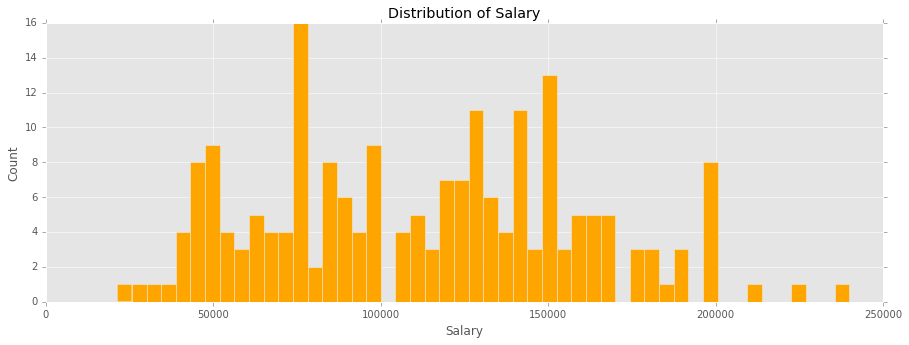

In [114]:
#take a look at the original plot of salaries

indcsvmore["Salary"].plot(kind = "hist", figsize = (15,5), color = "orange", bins = 50)

ax = plt.gca()
ax.set_title("Distribution of Salary")
ax.set_ylabel("Count")
ax.set_xlabel("Salary")
plt.show()

In [38]:
#calculate the median

print indcsv["Salary"].median()

117234.5


In [39]:
#write a function that creates the target variable of high or low if above or below the median

def highlow(boops):
    if boops == np.nan:
        return np.nan
    elif boops > 117234.5:
        return "High"
    elif boops <= 117234.5:
        return "Low"        

In [40]:
#apply the function

indcsv["SalaryBinary"] = indcsv["Salary"].apply(highlow)

In [41]:
#sort the data table to see how if it worked

indcsv.sort_values("Salary", ascending = False).head(10)

,Title,Location,Salary,Company,SalaryBinary
2084,Chief Data Scientist,"Boston, MA 02116 (South End area)",240000.0,Jobspring Partners,High
146,Quantitative Analyst for Global Quant Fund,"New York, NY",225000.0,Averity,High
556,Practice Leader for Management Consulting in P...,"Charlotte, NC",212500.0,BIG 6 Search International,High
277,Junior Quantitative Analyst / Developer for $5...,"New York, NY",200000.0,Averity,High
2114,Software Engineer - Machine Learning Team,"Boston, MA",200000.0,NJF Search,High
252,Quantitative Analyst (Fundamental Quant Equiti...,"New York, NY 10022 (Midtown area)",200000.0,Datacom Technology Group,High
391,Senior/ Lead Data Scientist for Digital Media ...,"New York, NY",200000.0,Averity,High
1937,Quantitative Researcher - Statistical Machine ...,"Berkeley, CA",200000.0,NJF Search,High
134,Data Scientist,"Armonk, NY",200000.0,Technical Source,High
1169,"Quantitative Researcher, Machine Learning & Ba...","Chicago, IL",200000.0,NJF Search,High


use location only as the first run

In [42]:
#make the target variable a dummy variable

indcsvrun = pd.concat([indcsv, pd.get_dummies(indcsv["SalaryBinary"])], axis = 1)

In [43]:
indcsvrun.head()

,Title,Location,Salary,Company,SalaryBinary,High,Low
0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University,None,0.0,0.0
1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post,None,0.0,0.0
2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg,None,0.0,0.0
3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant,None,0.0,0.0
4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center,None,0.0,0.0


In [44]:
#drop one of the variables and set the "high" one as target

del indcsvrun["Low"]
y = indcsvrun["High"]

In [46]:
#drop all NAs

indcsvrun.dropna(subset = ["Salary"], inplace = True)

In [48]:
#notice that locations don't have the same name even though they are for specific regions - these have ot be converted

indcsvrun["Location"].unique()

array(['New York, NY', 'New York, NY 10105 (Midtown area)',
       'New York, NY 10032 (Washington Heights area)', 'Armonk, NY',
       'Jefferson Valley-Yorktown, NY',
       'New York, NY 10017 (Midtown area)', 'Manhattan, NY',
       'New York, NY 10018 (Clinton area)',
       'New York, NY 10167 (Midtown area)',
       'New York, NY 10022 (Midtown area)', 'Queens, NY', 'Albany, NY',
       'Brooklyn, NY', 'Charlotte, NC 28202 (Downtown Charlotte area)',
       'Charlotte, NC', 'Chicago, IL', 'Chicago, IL 60603 (Loop area)',
       'Deerfield, IL', 'Des Plaines, IL', 'Hines, IL', 'Bloomingdale, IL',
       'Northbrook, IL 60062', 'San Francisco, CA',
       'San Francisco, CA 94104 (Financial District area)',
       'San Francisco Bay Area, CA', 'Berkeley, CA', 'Oakland, CA',
       'Brisbane, CA', 'San Mateo, CA 94402 (Beresford area)',
       'San Francisco, CA 94108 (Financial District area)',
       'San Mateo, CA', 'Boston, MA', 'Boston, MA 02116 (South End area)',
       'Camb

In [49]:
#wrote a function to change all the surrounding areas to apply to the original regions in the search field

def citieschange(boops):
    if "CA" in boops:
        return "San Francisco"
    elif "WA" in boops:
        return "Seattle"
    elif "IL" in boops:
        return "Chicago"
    elif "NY" in boops:
        return "New York"
    elif "TX" in boops:
        return "Austin"
    elif "MA" in boops:
        return "Boston"
    elif "OR" in boops:
        return "Portland"
    elif "CO" in boops:
        return "Denver"
    elif "Raleigh" in boops:
        return "Raleigh"
    elif "Triangle" in boops:
        return "Raleigh"
    elif "Wake" in boops:
        return "Raleigh"
    elif "Chapel" in boops:
        return "Raleigh"
    elif "Durham" in boops:
        return "Raleigh"
    elif "Charlotte" in boops:
        return "Charlotte"
    else:
        return boops

indcsvrun["Location"] = indcsvrun["Location"].apply(citieschange)

In [51]:
#checked that these worked

indcsvrun["Location"].unique()

array(['New York', 'Charlotte', 'Chicago', 'San Francisco', 'Boston',
       'Denver', 'Austin', 'Raleigh', 'Portland', 'Seattle'], dtype=object)

In [52]:
#convert locations to dummies

indcsvrun = pd.concat([indcsvrun, pd.get_dummies(indcsvrun["Location"])], axis = 1)

In [540]:
#set the X variable by dropping one city

X2 = indcsvrun.drop(["Title", "Location", "Salary", "Company", "SalaryBinary", "High", "Austin"], 1)

In [541]:
X2.head()

,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle
33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [542]:
X2.shape

(203, 9)

In [543]:
y2 = indcsvrun["High"]

Begin to run a logistic regression

In [545]:
#grid searched against a series of penalties and Cs

logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X2, y2)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [546]:
#print best parameter

gs.best_params_

{'C': 0.75, 'penalty': 'l1'}

In [547]:
#train test split with 33% and apply the best parameters to a logistic regression

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33)
lr = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty']) 
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

In [548]:
#print the confusion matrix - did ok.

lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,0.0,1.0
0.0,24,9
1.0,12,22


In [550]:
#print the classification report - did ok. 

print(classification_report(y_test, lr_ypred, labels=lr.classes_))

             precision    recall  f1-score   support

        0.0       0.67      0.73      0.70        33
        1.0       0.71      0.65      0.68        34

avg / total       0.69      0.69      0.69        67



In [554]:
#Logistic regression with no extra doodads actually did slightly better but not by much

lr2 = LogisticRegression() 
lr2_model = lr2.fit(X_train, y_train)
lr2_ypred = lr2_model.predict(X_test)
lr2_cm = confusion_matrix(y_test, lr2_ypred, labels=lr2.classes_)
lr2_cm = pd.DataFrame(lr2_cm, columns=lr2.classes_, index=lr2.classes_)
lr2_cm

,0.0,1.0
0.0,24,9
1.0,10,24


In [555]:
#classification report shows that it did better

print(classification_report(y_test, lr2_ypred, labels=lr2.classes_))

             precision    recall  f1-score   support

        0.0       0.71      0.73      0.72        33
        1.0       0.73      0.71      0.72        34

avg / total       0.72      0.72      0.72        67



Try a few more variables aside from just location

In [501]:
#see what we can do with the titles

indcsvrun["Title"].unique

<bound method Series.unique of 33                                  STATISTICIAN, LEVEL I
36                        Machine Learning Data Scientist
39                               AVP/Quantitative Analyst
61                    Sr. Machine Learning Data Scientist
85                          Lead/Principal Data Scientist
94                 Data Scientist - Advertising Analytics
102                          Data Scientist - Health+Care
128                          Assistant Research Scientist
134                                        Data Scientist
143                                        Data Scientist
145                         Senior Data Scientist ($150k)
146            Quantitative Analyst for Global Quant Fund
150                                        Data Scientist
153                                 Data Scientist (Lead)
158     Data Analyst, Bureau of Environmental Sciences...
170                                        Data Scientist
175                                      

Will use the following words as features in for titles:
    - Senior / Sr
    - Engineer
    - Analyst 
    - Statistician
    - Specialist
    - Manager
    - all other words will be treated as n/a

In [97]:
#write a function that does what has been described above

def titletest(boops):
    if "Senior" in boops:
        return "Senior"
    elif "senior" in boops:
        return "Senior"
    elif "sr" in boops:
        return "Senior"
    elif "Sr" in boops:
        return "Senior"
    elif "Engineer" in boops:
        return "Engineer"
    elif "engineer" in boops:
        return "Engineer"
    elif "Analyst" in boops:
        return "Analyst"
    elif "analyst" in boops:
        return "Analyst"
    elif "Statistician" in boops:
        return "Statistician"
    elif "statistician" in boops:
        return "Statistician"
    elif "specialist" in boops:
        return "Specialist"
    elif "Specialist" in boops:
        return "Specialist"
    elif "manager" in boops:
        return "Manager"
    elif "Manager" in boops:
        return "Manager"
    else:
        return "Other"

In [98]:
#apply this to the data frame

indcsvrun["Title Features"] = indcsvrun["Title"].apply(titletest)

In [100]:
#take a look at how many ended up with this result 

indcsvrun["Title Features"].value_counts()

Other           109
Senior           34
Analyst          26
Engineer         13
Manager          11
Specialist        6
Statistician      4
Name: Title Features, dtype: int64

In [101]:
#anything that does not fit the Title FEatures is being treated as a nan and thus is used as a base line in the dummies

indcsvmore = pd.concat([indcsvrun, pd.get_dummies(indcsvrun["Title Features"])], axis = 1)

In [508]:
#check to see if it worked

indcsvmore.head()

,Title,Location,Salary,Company,SalaryBinary,High,Austin,Boston,Charlotte,Chicago,...,Raleigh,San Francisco,Seattle,Title Features,Analyst,Engineer,Manager,Senior,Specialist,Statistician
33,"STATISTICIAN, LEVEL I",New York,51363.0,POLICE DEPARTMENT,Low,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
36,Machine Learning Data Scientist,New York,132500.0,All-In Analytics,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Analyst,1.0,0.0,0.0,0.0,0.0,0.0
61,Sr. Machine Learning Data Scientist,New York,130000.0,Wade & Wendy,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Senior,0.0,0.0,0.0,1.0,0.0,0.0
85,Lead/Principal Data Scientist,New York,165000.0,Empiric Solutions,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [572]:
#since going to try stats model, add in an intercept column

indcsvmore["intercept"] = 1

In [573]:
indcsvmore.columns

Index([u'Title', u'Location', u'Salary', u'Company', u'SalaryBinary', u'High',
       u'Austin', u'Boston', u'Charlotte', u'Chicago', u'Denver', u'New York',
       u'Portland', u'Raleigh', u'San Francisco', u'Seattle',
       u'Title Features', u'Analyst', u'Engineer', u'Manager', u'Senior',
       u'Specialist', u'Statistician', u'intercept'],
      dtype='object')

In [593]:
#dropped austin and dropped the imaginary np.nan for features - this one is without the intercept

X = indcsvmore.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22]]

In [512]:
y.shape

(203,)

In [574]:
X.shape

(203, 16)

In [579]:
#this includes the intercept

X2s = indcsvmore.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23]]

In [586]:
#convert to matrix to use for stats model 

Xss = X2s.as_matrix(columns=None)
yss = y.as_matrix(columns=None)

In [588]:
#fit to stats model logistic regression

mdl = sm.MNLogit(yss, Xss)
mdl_fit = mdl.fit()

         Current function value: 0.531564
         Iterations: 35


/Users/katty/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [589]:
#print summary

mdl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:                        MNLogit   Df Residuals:                      187
Method:                           MLE   Df Model:                           15
Date:                Wed, 06 Jul 2016   Pseudo R-squ.:                  0.2331
Time:                        15:32:00   Log-Likelihood:                -107.91
converged:                      False   LL-Null:                       -140.71
                                        LLR p-value:                 2.684e-08
==============================================================================
       y=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.0092      0.851      1.186      0.236        -0.659     2.678
x2            21.8821    1.3e+04      0.002      0.999     -2.55e+04  2.56e+04
x3             2.0162      0.820      2.458      0.014         0.409     3.624
x4            -0.1568      1.069     -0.147      0.883        -2.251     1.938
x5             1.2268      0.774      1.585      0.113        -0.290     2.743
x6           -18.1191   1.53e+04     -0.001      0.999        -3e+04     3e+04
x7             0.6914      0.986      0.701      0.483        -1.241     2.624
x8             2.4169      0.850      2.845      0.004         0.752     4.082
x9             2.1980      0.954      2.304      0.021         0.328     4.068
x10           -0.7345      0.518     -1.419      0.156        -1.749     0.280
x11            0.8360      0.670      1.248      0.212        -0.477     2.149
x12           -0.6618      0.794     -0.833      0.405        -2.219     0.895
x13            1.8468      0.554      3.335      0.001         0.761     2.932
x14           -0.8485      1.191     -0.712      0.476        -3.184     1.487
x15          -45.6972   4.88e+09  -9.37e-09      1.000     -9.56e+09  9.56e+09
const         -1.5464      0.742     -2.084      0.037        -3.001    -0.092
==============================================================================
"""

did not do well at all

attempt this with scikitlearn

In [599]:
#try gridsearch

logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X, y)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [600]:
#print best parameters

gs.best_params_

{'C': 0.0001, 'penalty': 'l2'}

In [601]:
#train test split at 33% and fit to best parameters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
lr = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty']) 
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

In [602]:
#print confusion matrix

lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,0.0,1.0
0.0,27,7
1.0,19,14


In [603]:
#did not perform better than location only

print(classification_report(y_test, lr_ypred, labels=lr.classes_))

             precision    recall  f1-score   support

        0.0       0.59      0.79      0.68        34
        1.0       0.67      0.42      0.52        33

avg / total       0.63      0.61      0.60        67



In [604]:
#fit without the gridsearch

lr2 = LogisticRegression() 
lr2_model = lr2.fit(X_train, y_train)
lr2_ypred = lr2_model.predict(X_test)

lr2_cm = confusion_matrix(y_test, lr2_ypred, labels=lr2.classes_)
lr2_cm = pd.DataFrame(lr2_cm, columns=lr2.classes_, index=lr2.classes_)
lr2_cm

,0.0,1.0
0.0,26,8
1.0,14,19


In [606]:
#definitely performed better than gridsearch but not that much better than location only

print(classification_report(y_test, lr2_ypred, labels=lr2.classes_))

             precision    recall  f1-score   support

        0.0       0.65      0.76      0.70        34
        1.0       0.70      0.58      0.63        33

avg / total       0.68      0.67      0.67        67



In [614]:
# print a few more scores

print "accuracy score: ", accuracy_score(y_test, lr2_ypred)
print "auc: ", roc_auc_score(y_test, lr2_ypred)
print "precision score: ", precision_score(y_test, lr2_ypred)
print "recall score: ", recall_score(y_test, lr2_ypred)

accuracy score:  0.671641791045
auc:  0.670231729055
precision score:  0.703703703704
recall score:  0.575757575758


incorporate more features - the addition of title didn't do too much

In [628]:
#take a look if there's anything that can be done for company

indcsvmore["Company"].unique()

array(['POLICE DEPARTMENT', 'All-In Analytics', 'AllianceBernstein',
       'Wade & Wendy', 'Empiric Solutions',
       'Research Foundation for Mental Hygiene, Inc.', 'Technical Source',
       'New York State Senate', 'Averity', 'TalentHub Worldwide',
       'Smart Host', 'DEPT OF HEALTH/MENTAL HYGIENE',
       'Datacom Technology Group', 'Smith Hanley Associates',
       'Columbia University', 'City of New York', 'Selby Jennings',
       'Emerald Resource Group', 'Helix Sleep',
       'NYC Dept. of Health and Mental Hygiene',
       "ADMIN FOR CHILDREN'S SVCS",
       'Research Foundation of The City University of New...',
       'Princeton Consulting', 'NYC Department of Buildings',
       'NYC Health + Hospitals', 'Univision communications inc',
       'DEPARTMENT OF SANITATION',
       'Environmental Conservation, Department of',
       'Workbridge Associates', 'Lighthouse Recruiting', 'Access Staffing',
       'Parker and Lynch', 'Smith Arnold Partners', '3coast',
       'HRA/DE

Consider using the following as features for company:

* education: "university", "school", "college"
* hospital/health: "hospital, hospitals, cancer, health"
* government: "department, dept"

In [79]:
#write a function to help do the above with the company one

def companychange(boops):
    if "university" in boops:
        return "Education"
    elif "University" in boops:
        return "Education"
    elif "College" in boops:
        return "Education"
    elif "college" in boops:
        return "Education" 
    elif "School" in boops:
        return "Education" 
    elif "school" in boops:
        return "Education"
    elif "department" in boops:
        return "Government"
    elif "Department" in boops:
        return "Government"
    elif "dept"in boops:
        return "Government"
    elif "Dept" in boops:
        return "Government"
    elif "State" in boops:
        return "Government"
    elif "state" in boops:
        return "Government"
    elif "DEPARTMENT" in boops:
        return "Government"
    elif "hospital" in boops:
        return "Healthcare"
    elif "hospitals" in boops:
        return "Healthcare"
    elif "Hospital" in boops:
        return "Healthcare"
    elif "Hospitals" in boops:
        return "Healthcare"
    elif "Cancer" in boops:
        return "Healthcare"
    elif "cancer" in boops:
        return "Healthcare"
    elif "health" in boops:
        return "Healthcare"
    elif "Health" in boops:
        return "Healthcare"
    elif "center" in boops:
        return "Healthcare"
    elif "Center" in boops:
        return "Healthcare"
    else:
        return "Other"

In [80]:
#apply changes

indcsvmore["Company Features"] = indcsvmore["Company"].apply(companychange)

In [81]:
#check that this actually works

indcsvmore["Company Features"].unique()

array(['Government', 'Other', 'Education', 'Healthcare'], dtype=object)

In [82]:
indcsvmore["Company Features"].value_counts()

Other         160
Education      22
Government     16
Healthcare      5
Name: Company Features, dtype: int64

In [102]:
#make into dummies and make into new data frame

indcsvmore1 = pd.concat([indcsvmore, pd.get_dummies(indcsvmore["Company Features"])], axis = 1)

KeyError: 'Company Features'

### Take a look at our full distribution of features now that we have all of them

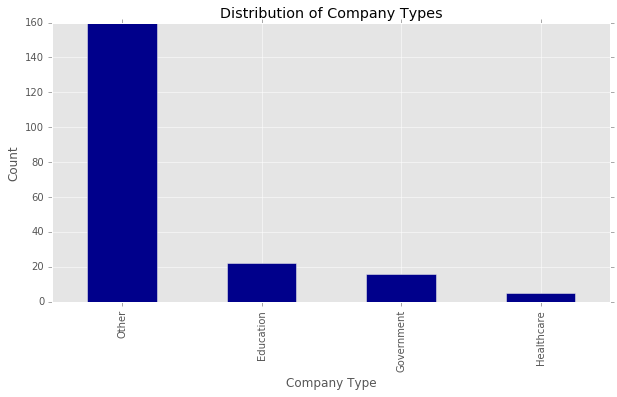

In [92]:
#take a look at company types

pd.value_counts(indcsvmore1["Company Features"]).plot(kind = "bar", figsize = (10,5), color = "darkblue")

ax = plt.gca()
ax.set_title("Distribution of Company Types")
ax.set_ylabel("Count")
ax.set_xlabel("Company Type")
plt.show()

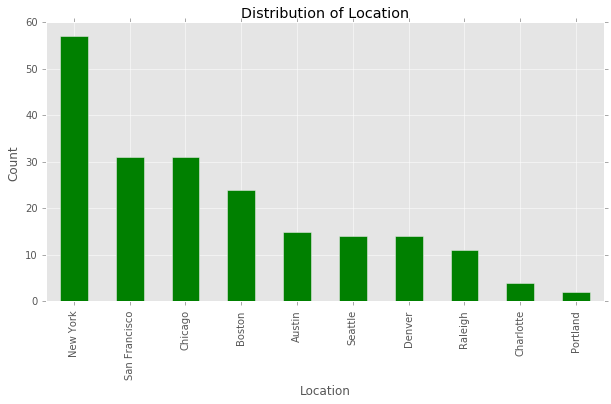

In [93]:
#take a look of distribution of locations

pd.value_counts(indcsvmore1["Location"]).plot(kind = "bar", figsize = (10,5), color = "green")

ax = plt.gca()
ax.set_title("Distribution of Location")
ax.set_ylabel("Count")
ax.set_xlabel("Location")
plt.show()

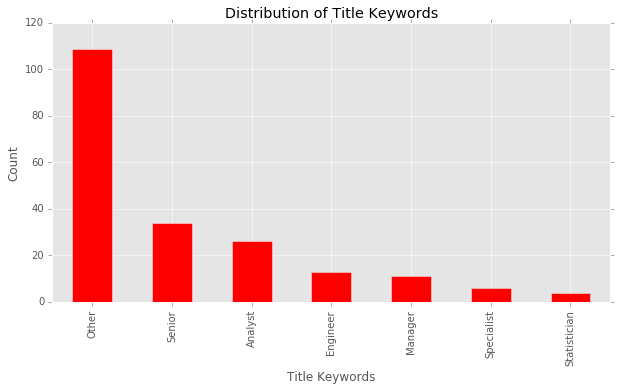

In [104]:
#take a look at title descriptions

pd.value_counts(indcsvmore["Title Features"]).plot(kind = "bar", figsize = (10,5), color = "red")

ax = plt.gca()
ax.set_title("Distribution of Title Keywords")
ax.set_ylabel("Count")
ax.set_xlabel("Title Keywords")
plt.show()

In [656]:
del indcsvmore1["intercept"]
indcsvmore1.head()

,Title,Location,Salary,Company,SalaryBinary,High,Austin,Boston,Charlotte,Chicago,...,Analyst,Engineer,Manager,Senior,Specialist,Statistician,Company Features,Education,Government,Healthcare
33,"STATISTICIAN, LEVEL I",New York,51363.0,POLICE DEPARTMENT,Low,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Government,0.0,1.0,0.0
36,Machine Learning Data Scientist,New York,132500.0,All-In Analytics,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
61,Sr. Machine Learning Data Scientist,New York,130000.0,Wade & Wendy,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
85,Lead/Principal Data Scientist,New York,165000.0,Empiric Solutions,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0


In [677]:
#set the final X

X_finalcv = indcsvmore1.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26]]

In [678]:
#set the final y

y_finalcv = indcsvmore1["High"]

In [679]:
#attempt logistic regression for all 3 feature categories

logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X_finalcv, y_finalcv)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [685]:
#fit to gridsearch lr, and print confusion matrix

X_train, X_test, y_train, y_test = train_test_split(X_finalcv, y_finalcv, test_size=0.33)
lr = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty']) 
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,0.0,1.0
0.0,27,5
1.0,14,21


In [688]:
#did marginally better than before

print(classification_report(y_test, lr_ypred, labels=lr.classes_))
print cross_val_score(lr, X_finalcv, y_finalcv, cv=5).mean()

             precision    recall  f1-score   support

        0.0       0.66      0.84      0.74        32
        1.0       0.81      0.60      0.69        35

avg / total       0.74      0.72      0.71        67

0.661120789779


In [689]:
#check the coefficients

lr_model.coef_

array([[-0.01393623,  0.01498557,  0.0290792 , -0.03250664, -0.02073666,
        -0.00464901, -0.00920429,  0.04695336,  0.01028424, -0.04685126,
         0.0103617 , -0.02299791,  0.07998058, -0.0145017 , -0.01910134,
        -0.07605302, -0.06641964, -0.01926149]])

In [690]:
indcsvmore1.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26,27]].head()

,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle,Analyst,Engineer,Manager,Senior,Specialist,Statistician,Education,Government,Healthcare,intercept
33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


San Francisco, and Senior are the most positively correlated - THIS IS THE FINAL MODEL

In [115]:
#print the fancy confusion matrix

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True Label', size = 12)
    plt.xlabel('Predicted Label', size = 12)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()])

In [116]:
plot_confusion_matrix(lr_cm, title='Confusion Matrix - High or Low Salary', labels=['Low','High'], cmap=plt.cm.Greens)

NameError: name 'lr_cm' is not defined